In [1]:
import pandas as pd


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings("ignore")

class Model(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size, dropouts):
        super().__init__()
        if hidden_sizes is None:
            hidden_sizes = [48, 32, 19]
        layers = [] # initialize layers
        layers.append(nn.Linear(input_size, hidden_sizes[0])) # first layer
        for i in range(len(hidden_sizes)-1):
            layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1])) # append each hidden layer
        self.layers = nn.ModuleList(layers) # read more about module lists for pytorch
        self.output = nn.Linear(hidden_sizes[len(hidden_sizes)-1], output_size)
        self.dropouts = nn.ModuleList([nn.Dropout(dropout) for dropout in dropouts])
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layers[0](x))
        x = self.dropouts[0](x)
        x = self.relu(self.layers[1](x))
        x = self.dropouts[1](x)
        x = self.relu(self.layers[2](x))
        x = self.dropouts[2](x)
        x = self.output(x)
        return x

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_ANN(data, features_lag, features_addtl, target, date_col, n_ahead, year_test_start, year_test_end):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # use GPU
    # Select relevant columns
    rel_col = features_lag + [target] + [date_col]
    data = data[rel_col]
    data[date_col] = pd.to_datetime(data[date_col])
    # Define lags
    env_lags = range(n_ahead,12+n_ahead)  # 4-week lag for environment features
    cases_lag = range(n_ahead, 12+n_ahead)  # n to 11 week lags for target variable

    # Create lagged features for environment and target variables
    for lag in env_lags:
        for feature in features_lag:
            data[f'{feature}_lag_{lag}'] = data[feature].shift(lag)

    for lag in cases_lag:
        data[f'{target}_lag_{lag}'] = data[target].shift(lag)

    # Remove any rows with missing values due to lagging
    data = data.dropna()

    # Initialize list for storing predictions
    predict_data = []
    actual_data = []
    # Split data into training and testing sets
    if year_test_end == "2024-12-31":
        train_data = data[data[date_col] < year_test_start]
    else:
        train_data = data[(data[date_col] < year_test_start) | (data[date_col] >= year_test_end)]
    test_data = data[(data[date_col] >= year_test_start) & (data[date_col] < year_test_end)]

    X_train = train_data.drop(columns=[target, date_col])
    y_train = train_data[target]
    X_test = test_data.drop(columns=[target, date_col])
    y_test = test_data[target]

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)
    X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    # Combine inputs and labels into a Dataset
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

    # Initialize the ANN Model
    input_size = X_train.shape[1]
    hidden_sizes = [48, 32, 19]
    dropouts = [0.3, 0.2, 0.1]
    output_size = 1
    model = Model(input_size, hidden_sizes, output_size, dropouts)
    model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    loss_history = []
    # Train the model
    model.train()
    num_epochs = 1000
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            # Get model predictions
            predictions = model(batch_X)

            # Compute loss (MSE)
            loss = loss_fn(predictions.squeeze(), batch_y)
            loss_history.append(loss.item())
            # Backpropagation
            loss.backward()
            optimizer.step()
            #print loss

    # Evaluate on test data
    model.eval()
    with torch.no_grad():
        predictions = model(X_test).squeeze().cpu().numpy()
        actual_y = y_test.cpu().numpy()
        predict_data.extend(predictions)
        actual_data.extend(actual_y)
    # Make predictions integer
    # Calculate Mean Absolute Error
    MAE = mean_absolute_error(actual_data, predict_data)
    MSE = mean_squared_error(actual_data, predict_data)
    return predict_data, MAE, MSE

In [4]:
import sys
sys.path.append('..')
import models_utils
#Ajuy = pd.read_csv("../../data/Merged Data/Ajuy_merged.csv")
#Ajuy["Year-Week"] = pd.to_datetime(Ajuy["Year-Week"])
#predicted, MAE, MSE = train_ANN(Ajuy, features=["Temperature", "Precipitation", "Humidity"], target="Cases", date_col="Year-Week", n_ahead=1, year_test_start="2023-01-01", year_test_end="2024-12-31")

In [5]:
municipals = []
with (open("../municipals.txt", "r") as f):
    for line in f:
        municipals.append(line.strip())

In [6]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
for municipal in municipals:
    for n in n_weeks_ahead:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        predicted, MAE, MSE = train_ANN(municipal_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Week", "Population", "Month"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start="2023-01-01", year_test_end="2024-12-31")
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, "Municipal")

KeyboardInterrupt: 

In [10]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

def train_ANN_pooled(data, X_train, y_train):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # use GPU
    #
    data = data.dropna()

    predict_data = []
    actual_data = []
   

    # Convert to PyTorch tensors
    X_train = torch.tensor(X_train.values, dtype=torch.float32).to(device)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).to(device)

    # Combine inputs and labels into a Dataset
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

    # Initialize the ANN Model
    input_size = X_train.shape[1]
    hidden_sizes = [48, 32, 18]
    dropouts = [0.3, 0.2, 0.1]
    output_size = 1
    model = Model(input_size, hidden_sizes, output_size, dropouts)
    model.to(device)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    loss_fn = nn.MSELoss()
    loss_history = []
    # Train the model
    model.train()
    num_epochs = 1000
    for epoch in range(num_epochs):
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()

            # Get model predictions
            predictions = model(batch_X)

            # Compute loss (MSE)
            loss = loss_fn(predictions.squeeze(), batch_y)
            loss_history.append(loss.item())
            # Backpropagation
            loss.backward()
            optimizer.step()
    return model

def test_ANN_pooled(model, X_test, y_test):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # use GPU

    # Convert to tensors and move to device
    X_test = torch.tensor(X_test.values, dtype=torch.float32).to(device)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(X_test).squeeze().cpu().numpy()
        actual_y = y_test.cpu().numpy()

    # Round predictions to nearest integer

    # Calculate error metrics
    MAE = mean_absolute_error(actual_y, predictions)
    MSE = mean_squared_error(actual_y, predictions)

    return predictions, MAE, MSE


In [8]:
pooled_df = pd.DataFrame()
n = [1,2,3,4,5,6,7,8,9,10,11,12]
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    municipal_df["Municipal"] = municipal
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 1)
    pooled_df = pd.concat([pooled_df, municipal_df], axis=0)

In [9]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
import warnings
warnings.filterwarnings("ignore")
for n in n_weeks_ahead:

    pooled_df = pd.DataFrame()
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Municipal"] = municipal
        # lag the features
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        pooled_df = pd.concat([pooled_df, municipal_df], axis=0)

    pooled_df.dropna()
    pooled_X = pooled_df.drop(columns=["Cases", "Year-Week"])
    pooled_y = pooled_df["Cases"]
    pooled_X_train = pooled_X[pooled_df["Year-Week"] < "2023-01-01"]
    pooled_y_train = pooled_y[pooled_df["Year-Week"] < "2023-01-01"]
    model = train_ANN_pooled(pooled_df, pooled_X_train, pooled_y_train)
    for municipal in municipals:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
        municipal_X = municipal_df.drop(columns=["Cases", "Year-Week"])
        municipal_y = municipal_df["Cases"]
        municipal_X_test = municipal_X[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        municipal_y_test = municipal_y[(municipal_df["Year-Week"] >= "2023-01-01") & (municipal_df["Year-Week"] < "2024-12-31")]
        predicted, MAE, MSE = test_ANN_pooled(model, municipal_X_test, municipal_y_test)
        models_utils.save_data(municipal, n, MSE, MAE, predicted, municipal_df, type = "Provincial")

# Summed Provincial Model

In [6]:
import pandas as pd
summed_df_list = []
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 12)
    summed_df_list.append(municipal_df)
summed_df = models_utils.prepare_dataframe_summed(summed_df_list)
summed_df

,Year-Week,Temperature,Humidity,Precipitation,Cases,Population,Year,Month,Week
0,2014-06-23,28.030394,81.104451,73.800002,75.0,53490.250000,2014,6,26
1,2014-06-30,28.529429,78.460959,79.799997,82.0,53490.250000,2014,6,27
2,2014-07-07,27.314642,84.184116,95.700005,128.0,53490.250000,2014,7,28
3,2014-07-14,27.780572,83.082178,84.100003,138.0,53490.250000,2014,7,29
4,2014-07-21,27.530536,82.549960,163.300002,175.0,53490.250000,2014,7,30
...,...,...,...,...,...,...,...,...,...
544,2024-12-02,29.520965,75.235959,40.450002,135.0,58740.704545,2024,12,49
545,2024-12-09,28.585107,77.225192,55.400004,166.0,58740.704545,2024,12,50
546,2024-12-16,26.923679,85.136271,117.550004,133.0,58740.704545,2024,12,51
547,2024-12-23,27.754071,80.010136,68.600001,96.0,58740.704545,2024,12,52


In [10]:
n_head = range(1,13)
summed_df["Year-Week"] = pd.to_datetime(summed_df["Year-Week"])
for n in n_head:
    summed_df = models_utils.prepare_dataframe(summed_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", n)
    predicted, MAE, MSE = train_ANN(summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Week", "Population", "Month"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start="2023-01-01", year_test_end="2024-12-31")
    models_utils.save_data("summed", n, MSE, MAE, predicted, summed_df, "Summed Provincial")

In [13]:
import matplotlib.pyplot as plt

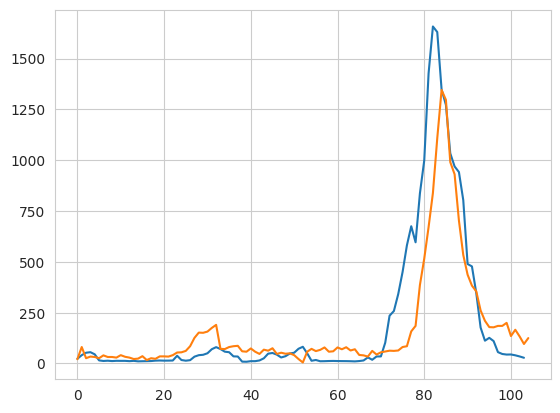

In [16]:
plt.plot(predicted, label="Predicted")
plt.plot(summed_df[summed_df["Year-Week"].dt.year >= 2023]["Cases"].values, label="Actual")

# Leave One Season Out
## Local

In [ ]:
n_weeks_ahead = [1,2,3,4,5,6,7,8,9,10,11,12]
years = range(2014, 2025)
leave_one_season_out_local_ann =  pd.DataFrame(columns=["Municipal", "Year", "MAE", "MSE", "N_week_ahead"])
for municipal in municipals:
    for n in n_weeks_ahead:
        municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
        municipal_df["Year-Week"] = pd.to_datetime(municipal_df["Year-Week"])
        for year in years:
            predicted, MAE, MSE = train_ANN(municipal_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Week", "Population", "Month"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start=f"{year}-01-01", year_test_end=f"{year}-12-31")
            leave_one_season_out_local_ann = pd.concat([leave_one_season_out_local_ann, pd.DataFrame({"Municipal": [municipal], "Year": [year], "MAE": [MAE], "MSE": [MSE], "N_week_ahead": [n]})], axis=0)


In [ ]:
leave_one_season_out_local_ann.to_csv("leave_one_season_out_evaluation.csv", index=False)

## Summed Provincial

In [7]:
for municipal in municipals:
    municipal_df = pd.read_csv(f"../../data/Merged Data/{municipal}_merged.csv")
    # lag the features
    municipal_df = models_utils.prepare_dataframe(municipal_df, ["Temperature", "Precipitation", "Humidity"], ["Year", "Week", "Month", "Population"], "Cases", "Year-Week", 12)
    summed_df_list.append(municipal_df)
summed_df = models_utils.prepare_dataframe_summed(summed_df_list)
summed_df

,Year-Week,Temperature,Humidity,Precipitation,Cases,Population,Year,Month,Week
0,2014-06-23,28.030394,81.104451,73.800002,150.0,53490.250000,2014,6,26
1,2014-06-30,28.529429,78.460959,79.799997,164.0,53490.250000,2014,6,27
2,2014-07-07,27.314642,84.184116,95.700005,256.0,53490.250000,2014,7,28
3,2014-07-14,27.780572,83.082178,84.100003,276.0,53490.250000,2014,7,29
4,2014-07-21,27.530536,82.549960,163.300002,350.0,53490.250000,2014,7,30
...,...,...,...,...,...,...,...,...,...
544,2024-12-02,29.520965,75.235959,40.450002,270.0,58740.704545,2024,12,49
545,2024-12-09,28.585107,77.225192,55.400004,332.0,58740.704545,2024,12,50
546,2024-12-16,26.923679,85.136271,117.550004,266.0,58740.704545,2024,12,51
547,2024-12-23,27.754071,80.010136,68.600001,192.0,58740.704545,2024,12,52


In [9]:
n_weeks_ahead = range(1,13)
years = range(2014,2025)
leave_one_season_out_summed_ann =  pd.DataFrame(columns=["Year", "MAE", "MSE", "N_week_ahead"])
for year in years:
    for n in n_weeks_ahead:
        predicted, MAE, MSE = train_ANN(summed_df, features_lag=["Temperature", "Precipitation", "Humidity"], features_addtl = ["Year", "Week", "Population", "Month"], target="Cases", date_col="Year-Week", n_ahead=n, year_test_start=f"{year}-01-01", year_test_end=f"{year}-12-31")
        leave_one_season_out_summed_ann = pd.concat([leave_one_season_out_summed_ann, pd.DataFrame({"Municipal": ["summed"], "Year": [year], "MAE": [MAE], "MSE": [MSE], "N_week_ahead": [n]})], axis=0)
        print(f'year {year} with {n}-ahead has passed')

year 2014 with 1-ahead has passed
year 2014 with 2-ahead has passed
year 2014 with 3-ahead has passed
year 2014 with 4-ahead has passed
year 2014 with 5-ahead has passed
year 2014 with 6-ahead has passed
year 2014 with 7-ahead has passed
year 2014 with 8-ahead has passed
year 2014 with 9-ahead has passed
year 2014 with 10-ahead has passed
year 2014 with 11-ahead has passed
year 2014 with 12-ahead has passed
year 2015 with 1-ahead has passed
year 2015 with 2-ahead has passed
year 2015 with 3-ahead has passed
year 2015 with 4-ahead has passed
year 2015 with 5-ahead has passed
year 2015 with 6-ahead has passed
year 2015 with 7-ahead has passed
year 2015 with 8-ahead has passed
year 2015 with 9-ahead has passed
year 2015 with 10-ahead has passed
year 2015 with 11-ahead has passed
year 2015 with 12-ahead has passed
year 2016 with 1-ahead has passed
year 2016 with 2-ahead has passed
year 2016 with 3-ahead has passed
year 2016 with 4-ahead has passed
year 2016 with 5-ahead has passed
year 201

In [10]:
leave_one_season_out_summed_ann.to_csv("leave_one_season_out_summed_evaluation.csv", index=False)


In [21]:
#leave_one_season_out_summed_ann.drop(columns=["Municipal"], inplace=True)
leave_one_season_out_summed_ann = pd.read_csv("leave_one_season_out_summed_evaluation.csv")
leave_one_season_out_summed_ann.drop(columns=["Municipal"], inplace=True)

In [22]:
leave_one_season_out_summed_ann["RMSE"] = leave_one_season_out_summed_ann["MSE"]**0.5
leave_one_season_out_summed_ann.groupby(["N_week_ahead"]).mean()

,Year,MAE,MSE,RMSE
N_week_ahead,,,,
1,2019.0,74.561423,27190.793566,115.860905
2,2019.0,88.792638,56929.046205,144.550368
3,2019.0,88.445288,44785.898213,135.561097
4,2019.0,95.745171,56592.701933,155.157203
5,2019.0,108.568979,92518.297607,184.053951
6,2019.0,131.127147,132518.599300,232.487127
7,2019.0,138.010086,173183.524527,254.784851
8,2019.0,158.082172,221832.466504,287.295097
9,2019.0,153.737015,209835.561279,267.084469


In [20]:
leave_one_season_out_summed_ann

,Year,MAE,MSE,N_week_ahead,Municipal,RMSE
0,2014,33.314330,1552.12560,1,summed,39.397025
1,2014,17.953169,479.75730,2,summed,21.903363
2,2014,17.391436,400.92618,3,summed,20.023141
3,2014,14.619084,317.58356,4,summed,17.820874
4,2014,15.363330,377.19498,5,summed,19.421508
...,...,...,...,...,...,...
127,2024,364.704130,413376.03000,8,summed,642.943256
128,2024,267.446350,211555.89000,9,summed,459.952052
129,2024,302.418240,246241.27000,10,summed,496.227035
130,2024,382.973270,417012.84000,11,summed,645.765313
